# Importing Libraries


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping, ModelCheckpoint


# Load and Visualizing Datasets

In [2]:
test_path = "/kaggle/input/surface-crack/test/"
train_path = "/kaggle/input/surface-crack/train/"

In [3]:
import pandas as pd
def df_gen_(path):
    list_data = [[],[]]
    
    for i in os.listdir(path):
#         label = i
        for j in os.listdir(path+i):
            list_data[0].append(path+i+'/'+j)
            list_data[1].append(i)
            
    return pd.DataFrame(list(zip(list_data[0], list_data[1])), columns =['File_Path', 'Label'])

In [4]:
data = df_gen_(train_path)

In [5]:
#initialize random seeds so results are repeatable
import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [6]:
train_df = df_gen_(train_path)
test_df = df_gen_(test_path)

# Functions

In [7]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.3)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42
        )

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, test_gen

In [8]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),alpha=1.0,
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = True
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(lr=0.0001)
    model.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    my_callbacks  = [ModelCheckpoint('model1-{epoch:03d}.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')]
    return model, my_callbacks



In [9]:
def plot(history,df_test,test_gen,train_gen):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    
    ## load best model (after training) to see confusion matrix
    
    #model=load_model(r"/content/gdrive/MyDrive/surfacedata/model1-008.h5")
    
    ##
    
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["NEGATIVE", "POSITIVE"])
    print(clr)
    print(cm)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history,cm

In [10]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

In [11]:
from tensorflow.keras.applications import VGG16,MobileNetV2, DenseNet121,NASNetMobile, MobileNetV3Small,VGG19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

net_pre=preprocess_input
train_gen_net ,test_gen_net = gen(net_pre,train_df,test_df)

Found 600 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [12]:
model, callback=func(MobileNetV2)


2023-01-25 19:13:37.931281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:13:38.013541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:13:38.014315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:13:38.016161: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Training

In [13]:
history = model.fit(
    train_gen_net,
    validation_data=test_gen_net ,
    epochs=200,
    callbacks=callback
)

2023-01-25 19:13:41.880604: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-01-25 19:13:47.032421: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 15s 454ms/step - loss: 0.5660 - accuracy: 0.7083 - val_loss: 0.5994 - val_accuracy: 0.7100


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
10/10 [==============================] - 2s 165ms/step - loss: 0.2233 - accuracy: 0.9333 - val_loss: 0.2949 - val_accuracy: 0.8600
Epoch 3/200
10/10 [==============================] - 2s 177ms/step - loss: 0.1077 - accuracy: 0.9767 - val_loss: 0.2497 - val_accuracy: 0.8850
Epoch 4/200
10/10 [==============================] - 2s 177ms/step - loss: 0.0492 - accuracy: 0.9933 - val_loss: 0.1610 - val_accuracy: 0.9300
Epoch 5/200
10/10 [==============================] - 2s 167ms/step - loss: 0.0325 - accuracy: 0.9983 - val_loss: 0.1821 - val_accuracy: 0.9300
Epoch 6/200
10/10 [==============================] - 2s 185ms/step - loss: 0.0165 - accuracy: 0.9983 - val_loss: 0.1309 - val_accuracy: 0.9550
Epoch 7/200
10/10 [==============================] - 2s 168ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.1426 - val_accuracy: 0.9450
Epoch 8/200
10/10 [==============================] - 2s 167ms/step - loss: 0.0095 - accuracy: 0.9983 - val_loss: 0.1593 - val_accuracy: 0.9250

# Plot results

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00       100
    POSITIVE       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

[[100   0]
 [  0 100]]


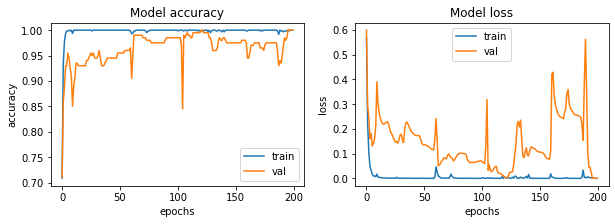

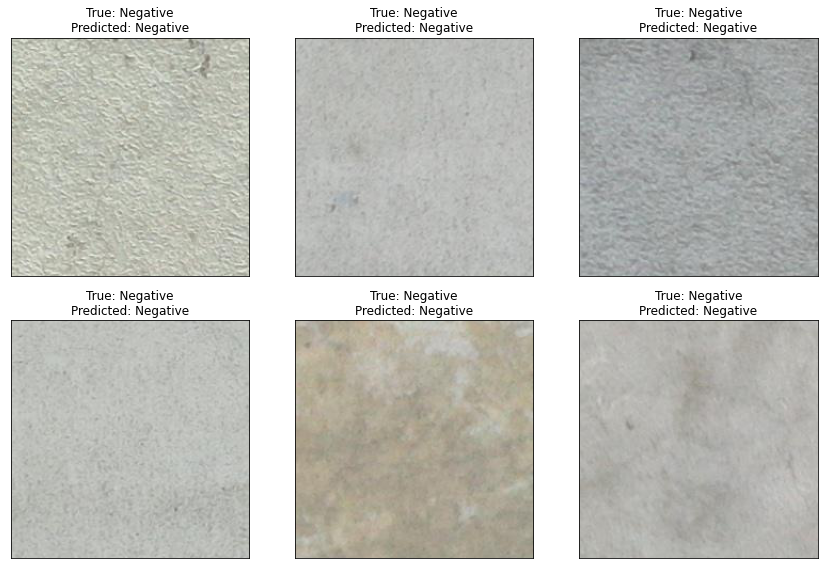

In [14]:
#before run this cell, choose the best model in plot function that commented.
history,cm=plot(history,test_df,test_gen_net,train_gen_net)

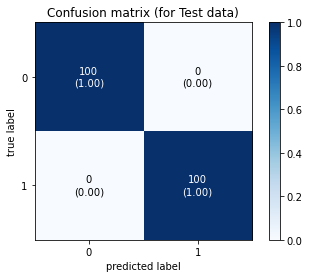

In [15]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix = cm
binary1 = conf_matrix 

fig, ax = plot_confusion_matrix(conf_mat=binary1,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.title('Confusion matrix (for Test data)')
plt.show()

In [16]:
result_myNet = result_test(test_gen_net,model)

    Test Loss: 0.00057
Test Accuracy: 100.00%


In [17]:
class custom(tf.keras.Model):

    def __init__(self):
        super(custom, self).__init__()
        self.pre = net_pre
        self.model = model

    def call(self, inputs):
        x = self.pre(tf.cast(inputs, tf.float32))
        return self.model(x)


new_model = custom()

In [18]:
import cv2
img_path = "/kaggle/input/surface-crack/predict/IMG_1129.JPG"
img =  cv2.resize(cv2.imread(img_path), (100, 100),interpolation = cv2.INTER_LINEAR)[:,:,::-1].reshape(1,100,100,3)

In [19]:
model(net_pre(img))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[9.9999928e-01, 7.6507075e-07]], dtype=float32)>

In [20]:
new_model(img)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[9.9999928e-01, 7.6507075e-07]], dtype=float32)>

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

2023-01-25 19:20:29.327601: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2023-01-25 19:20:45.408236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:20:45.408586: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-25 19:20:45.408708: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-25 19:20:45.409253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.